In [1]:
%load_ext autoreload
%autoreload 2

import os

from newspaper import Article
import newspaper
import spacy
import csv
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

# import local modules
from utils import *

In [2]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /home/murnanedaniel/miniconda3/etc/jupyter
    - Validating...
      voila 0.3.3 OK


## Test Interactive

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [4]:
grand = widgets.ToggleButtons(
            options=['grandson', 'granddaughter']
        )

In [5]:
grand

ToggleButtons(options=('grandson', 'granddaughter'), value='grandson')

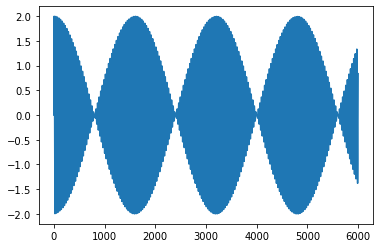

In [6]:
from ipywidgets import interactive
from IPython.display import Audio, display
import numpy as np

def beat_freq(f1=220.0, f2=224.0):
    max_time = 3
    rate = 8000
    times = np.linspace(0,max_time,rate*max_time)
    signal = np.sin(2*np.pi*f1*times) + np.sin(2*np.pi*f2*times)
    display(Audio(data=signal, rate=rate))
    return signal

v = interactive(beat_freq, f1=(200.0,300.0), f2=(200.0,300.0))
f1, f2 = v.children[:2]
f1.value = 255
f2.value = 260
plt.plot(v.result[0:6000]);

# Topic Detection

## Roadmap

1. Load some articles
2. Cluster in space
3. Identify a cluster C 
4. Identify the topic T of C
5. Search for other articles with the same topic T using Google API
6. Get the summaries of all these articles
7. Re-cluster the full topic T
8. For each day of the articles, build two clusters, representing perspectives P1 and P2
9. Get representative articles for each perspective PA1 and PA2

### Authenticate

In [33]:
#authenticate with OpenAI
openai.api_key = None


## Testing

In [8]:
openai.Engine.retrieve("ada")

<Engine engine id=ada at 0x7f06d660d130> JSON: {
  "created": null,
  "id": "ada",
  "max_replicas": null,
  "object": "engine",
  "owner": "openai",
  "permissions": null,
  "ready": null,
  "replicas": null
}

<OpenAIObject text_completion id=cmpl-4nftEpsBPuN2YUymIi30r5wRVWcy2 at 0x7fb740398450> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": " to see how you adapt"
    }
  ],
  "created": 1647744444,
  "id": "cmpl-4nftEpsBPuN2YUymIi30r5wRVWcy2",
  "model": "babbage:2020-05-03",
  "object": "text_completion"
}

In [16]:
embedding_response = openai.Embedding.create(
  input="Attacks on civilians intensify as Ukraine and Russia say negotiations indicate progress",
  engine="text-similarity-babbage-001"
)

In [29]:
embedding_response = openai.Embedding.create(
  input="Attacks on civilians intensify as Ukraine and Russia say negotiations indicate progress",
  engine="text-similarity-curie-001"
)

In [30]:
embedding = np.array(embedding_response["data"][0].embedding)

In [37]:
country_response = openai.Embedding.create(
  input="Russia",
  engine="text-similarity-curie-001"
)

In [34]:
country_response = openai.Embedding.create(
  input="Australia",
  engine="text-similarity-curie-001"
)

In [37]:
country_response = openai.Embedding.create(
  input="Russia",
  engine="text-similarity-curie-001"
)

In [38]:
country = np.array(country_response["data"][0].embedding)

With Curie:

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

With Curie:

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

In [39]:
np.dot(embedding, country) #Russia

0.6708284090871041

In [45]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, engine="text-similarity-davinci-001") -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    return openai.Embedding.create(input=[text], engine=engine)["data"][0]["embedding"]

In [46]:
embedding = get_embedding("Sample query text goes here", engine="text-search-ada-query-001")
print(len(embedding))

1024


In [47]:
embedding = get_embedding("Sample document text goes here", engine="text-search-ada-doc-001")
print(len(embedding))

1024


## Build Article List

In [34]:
wechat_urls = [
    "https://www.smh.com.au/politics/federal/how-wechat-is-helping-the-ccp-control-australian-media-outlets-20201216-p56nvp.html",
    "https://www.smh.com.au/politics/federal/beijing-controls-chinese-language-media-agencies-in-australia-says-intel-agency-20201202-p56k10.html",
    "https://www.smh.com.au/politics/federal/liberal-mps-pledge-to-boycott-wechat-after-pm-blocked-from-platform-20220124-p59qqj.html",
    "https://www.news.com.au/national/politics/unacceptable-gladys-liu-boycotts-wechat-over-political-interference-concerns/news-story/7e498b83f151bea27aa0f8d9fc386561",
    "https://7news.com.au/politics/wechat-hits-back-at-interference-claims-c-5432089",
    "https://www.scmp.com/news/china/diplomacy/article/3164999/australian-pms-wechat-transferred-new-owner-not-hacked-chinese",
    "https://www.abc.net.au/news/2022-01-30/scott-morrison-lost-control-wechat-account-china-relations/100787054",
    "https://www.msn.com/en-au/news/australia/chinese-businessman-reveals-why-he-bought-scott-morrison-s-wechat-account/ar-AAT5kb2?li=AAaeSy5"
]

In [35]:
wechat_articles = [Article(url) for url in wechat_urls]

In [36]:
smh_paper = newspaper.build('https://www.smh.com.au', memoize_articles=False)

In [37]:
num_random = 20
random_articles = smh_paper.articles[:num_random]

Download and parse ("digest") the article:

In [38]:
sample_articles = wechat_articles + random_articles

In [39]:
sample_articles = parse_articles(sample_articles)

<newspaper.article.Article object at 0x7f6d59b77a00> could not be downloaded
<newspaper.article.Article object at 0x7f6d59b77b20> could not be downloaded


In [40]:
sample_articles = interpret_articles(sample_articles)
sample_articles = interpret_articles(sample_articles)

(3, '') could not be processed
(4, '') could not be processed
(5, "Russia-Ukraine war timeline: How Vladimir Putin's invasion is progressing towards Kyiv") could not be summarized
(3, 'Australian PM’s WeChat transferred to new owner, not hacked, Chinese operator Tencent says') could not be summarized


In [41]:
article_embeddings = embed_articles(sample_articles)

In [42]:
X = np.stack(article_embeddings)

In [43]:
X.shape

(22, 2048)

## Visualize

In [139]:
pca = PCA(n_components=2)
articles2d = pca.fit_transform(X)

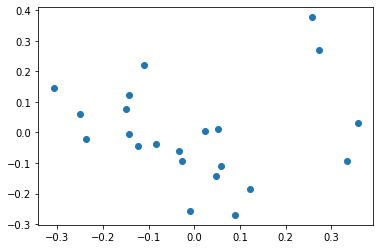

In [45]:
# plot the result
plt.scatter(articles2d[:, 0], articles2d[:, 1])

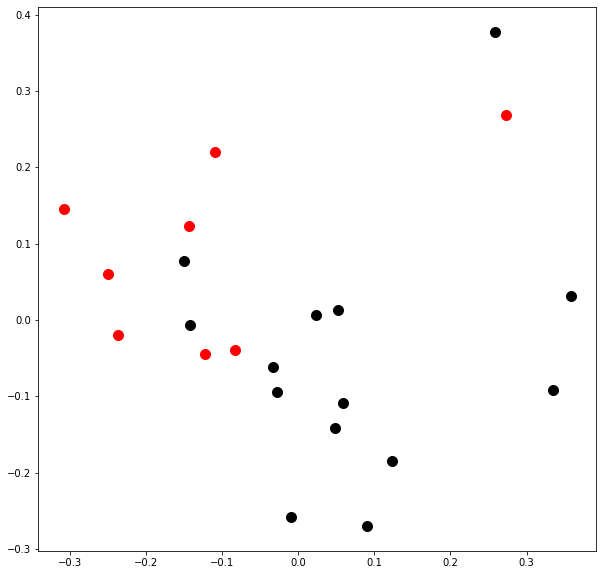

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
for article in articles2d[:len(wechat_urls)]:
    ax.scatter(article[0], article[1], s=100, c="r")
for article in articles2d[len(wechat_urls):]:
    ax.scatter(article[0], article[1], s=100, c="k")

## Predict Clusters

In [47]:
from sklearn.cluster import DBSCAN

In [65]:
clustering = DBSCAN(eps=0.65, min_samples=2).fit(X)

In [66]:
clustering.labels_

array([ 0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1])

In [67]:
[(article.title, article.source_url) for article in sample_articles[0:9]]

[('How WeChat is helping the CCP control Australian media outlets',
  'https://www.smh.com.au'),
 ('Beijing controls Chinese-language media agencies in Australia, says intel agency',
  'https://www.smh.com.au'),
 ('Liberal MPs pledge to boycott WeChat after PM blocked from platform',
  'https://www.smh.com.au'),
 ('Latest Real Estate News and Property Market Analysis',
  'https://www.smh.com.au/healthcare'),
 ('Russia gives ultimatum for Ukrainians in Mariupol to ‘lay down arms’',
  'https://www.smh.com.au'),
 ('China’s markets have roared back but Russia is the elephant in the room',
  'https://www.smh.com.au/business'),
 ('‘Hindsight is a powerful thing’: AustralianSuper CEO on exiting Russia',
  'https://www.smh.com.au/business'),
 ('Australia news LIVE: Russian and Ukrainian forces fight for control of Mariupol; South Australia swears in new premier',
  'https://www.smh.com.au'),
 ('FA investigating allegation Socceroos coach Arnold breached isolation order',
  'https://www.smh.com

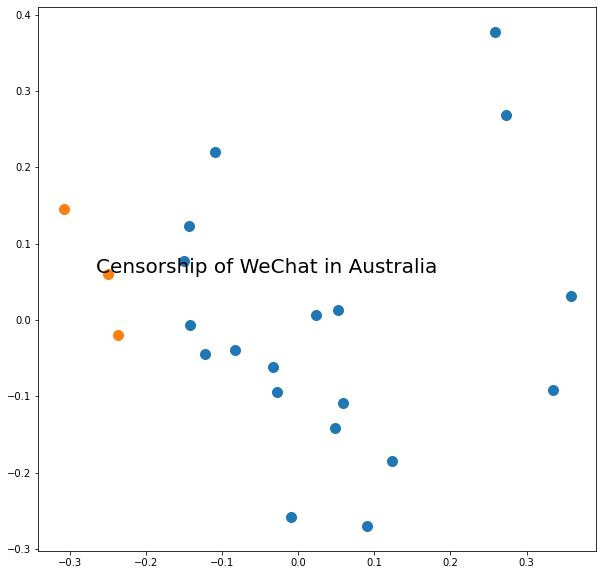

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(clustering.labels_):
    article_list = articles2d[clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)
    if label == 0:
        # Plot cluster_label text in center of cluster
        ax.text(article_list[:, 0].mean(), article_list[:, 1].mean(), cluster_label, fontsize=20)




In [69]:
cluster_av = np.mean(X[clustering.labels_ == 0], axis=0)

In [70]:
distances = np.sqrt(np.sum((cluster_av - X)**2, axis=1))

In [71]:
distances

array([0.31876919, 0.29093649, 0.38777134, 0.80943655, 0.65041165,
       0.65251283, 0.62906477, 0.67906967, 0.72946656, 0.71742184,
       0.73992096, 0.70968666, 0.71269423, 0.73092675, 0.71784646,
       0.6324413 , 0.69623913, 0.63760023, 0.84517086, 0.688997  ,
       0.83320093, 0.81831758])

## Get Topic of Cluster

In [73]:
# Get sample_articles where clustering == 0
cluster_titles = ". ".join([article.title for article in sample_articles if clustering.labels_[sample_articles.index(article)] == 0])

In [74]:
topic = get_topic(cluster_titles, "text-davinci-002")

In [75]:
cluster_label = topic["choices"][0]["text"].replace("\n", "")

In [76]:
topic

<OpenAIObject text_completion id=cmpl-4o1BuOVzzYI5qkSsrvDTETZZDhZ8e at 0x7f6d59b75ea0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\n\nCensorship of WeChat in Australia"
    }
  ],
  "created": 1647826326,
  "id": "cmpl-4o1BuOVzzYI5qkSsrvDTETZZDhZ8e",
  "model": "text-davinci:002",
  "object": "text_completion"
}

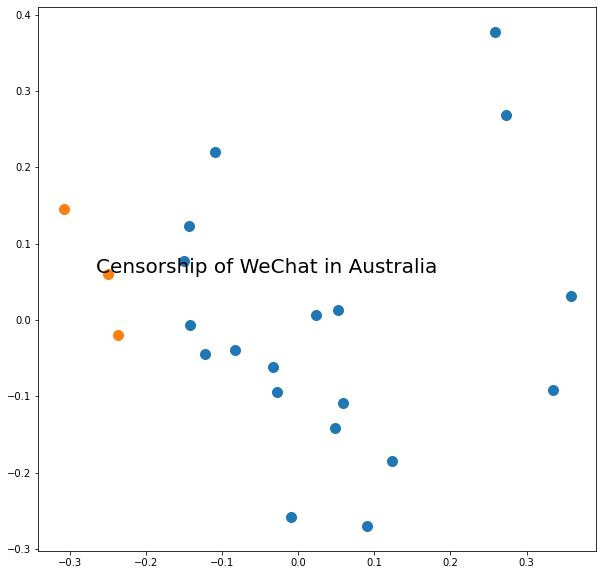

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(clustering.labels_):
    article_list = articles2d[clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)
    if label == 0:
        # Plot cluster_label text in center of cluster
        ax.text(article_list[:, 0].mean(), article_list[:, 1].mean(), cluster_label, fontsize=20)




## Find Related Articles

Get the keywords of the articles

In [96]:
import nest_asyncio
import aiohttp
import asyncio

In [78]:
cluster_articles = [article for article in sample_articles if clustering.labels_[sample_articles.index(article)] == 0]

In [79]:
# Aggregate all article keywords
cluster_keyword_list = [article.keywords for article in cluster_articles]

In [80]:
# Flatten list of lists
cluster_keyword_list = [keyword for sublist in cluster_keyword_list for keyword in sublist]

In [118]:
len(results[0]["entries"])

31

In [120]:
recency = 60
related_news_results = get_news_results(cluster_label, recency)

In [126]:
len(related_news_results)

16

In [128]:
related_news_results[0].keys()

dict_keys(['title', 'title_detail', 'links', 'link', 'id', 'guidislink', 'published', 'published_parsed', 'summary', 'summary_detail', 'source', 'sub_articles'])

In [129]:
related_news_results[0]["link"]

'https://www.dw.com/en/australian-pm-morrison-loses-control-over-wechat-account/a-60532243'

In [130]:
# Make Article list from related_news_results
related_news_articles = [Article(related_news_result["link"]) for related_news_result in related_news_results]

In [132]:
# Parse and interpret articles
related_news_articles = parse_articles(related_news_articles)
related_news_articles = interpret_articles(related_news_articles)

<newspaper.article.Article object at 0x7f6d5059ac10> could not be downloaded
<newspaper.article.Article object at 0x7f6d5059af10> could not be downloaded
<newspaper.article.Article object at 0x7f6d5059f610> could not be downloaded
(5, '') could not be processed
(6, '') could not be processed


In [136]:
# Embed articles
related_news_embeddings = embed_articles(related_news_articles)

In [140]:
# Visualise in PCA related embeddings
related_news_embeddings = np.stack(related_news_embeddings)
related_articles2d = pca.transform(related_news_embeddings)

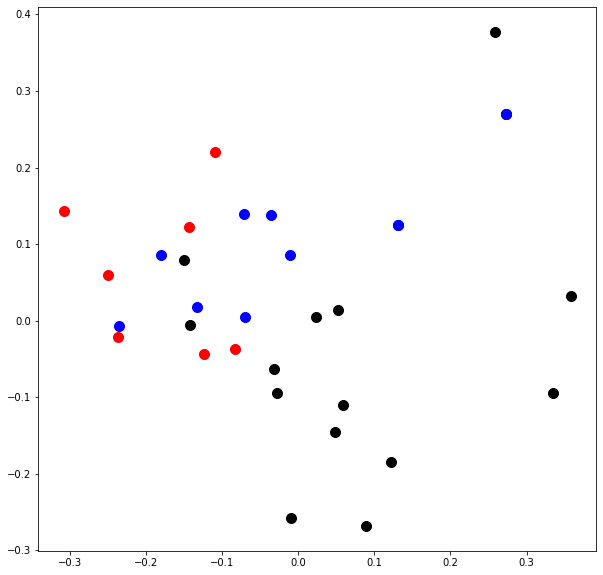

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
for article in articles2d[:len(wechat_urls)]:
    ax.scatter(article[0], article[1], s=100, c="r")
for article in articles2d[len(wechat_urls):]:
    ax.scatter(article[0], article[1], s=100, c="k")
for article in related_articles2d:
    ax.scatter(article[0], article[1], s=100, c="b")

In [144]:
# Get distance of related embeddings from average cluster embedding
related_distances = np.sqrt(np.sum((cluster_av - related_news_embeddings)**2, axis=1))
other_distances = np.sqrt(np.sum((cluster_av - X)**2, axis=1))

In [143]:
related_distances

array([0.41149301, 0.58041668, 0.68181251, 0.64576979, 0.75236009,
       0.80943655, 0.80943655, 0.70077292, 0.66798308, 0.75236009,
       0.57630296])

In [145]:
other_distances

array([0.31876919, 0.29093649, 0.38777134, 0.80943655, 0.65041165,
       0.65251283, 0.62906477, 0.67906967, 0.72946656, 0.71742184,
       0.73992096, 0.70968666, 0.71269423, 0.73092675, 0.71784646,
       0.6324413 , 0.69623913, 0.63760023, 0.84517086, 0.688997  ,
       0.83320093, 0.81831758])

In [146]:
# Get DBSCAN of all articles
clustering = DBSCAN(eps=0.65, min_samples=2).fit(np.concatenate((X, related_news_embeddings)))

In [147]:
clustering.labels_

array([ 0,  0,  0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1, -1,  3,  1,  1, -1,  2,  3,  0])